https://wikidocs.net/48649

## **08-07 문자 단위 RNN(Char RNN)**
---
지금까지 배운 RNN은 전부 입력과 출력의 단위가 단어 벡터였습니다. 하지만 입출력의 단위를 단어 레벨(word-level)에서 **문자 레벨(character-level)** 로 변경하여 RNN을 구현할 수 있습니다.

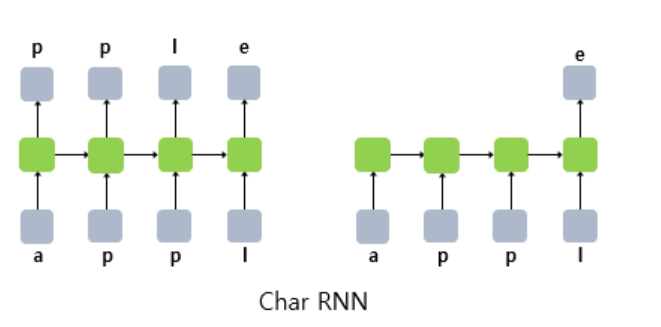

위의 그림은 문자 단위 RNN을 **다 대 다(Many-to-Many) 구조** 로 구현한 경우, **다 대 일(Many-to-One) 구조** 로 구현한 경우 두 가지를 보여줍니다. 여기서는 이 두 가지 모두 구현해보겠습니다. 첫번째로 구현할 것은 다 대 다 구조를 이용한 언어 모델입니다.

### **1. 글자 단위 RNN 언어 모델(Char RNNLM)**

이전 시점의 예측 문자를 다음 시점의 입력으로 사용하는 문자 단위 RNN 언어 모델을 구현해봅시다. 앞서 배운 단어 단위 RNN 언어 모델과 다른 점은 단어 단위가 아니라 문자 단위를 입, 출력으로 사용하므로 임베딩층(embedding layer)을 여기서는 사용하지 않겠습니다. 여기서는 언어 모델의 훈련 과정과 테스트 과정의 차이를 이해하는데 집중합니다.

다운로드 링크 : http://www.gutenberg.org/files/11/11-0.txt

고전 소설들은 저작권에 보호받지 않으므로 무료로 다운받을 수 있습니다. 위의 링크에서 '이상한 나라의 앨리스(Alice’s Adventures in Wonderland)'라는 소설을 다운로드 합니다.

#### **1) 데이터에 대한 이해와 전처리**
데이터를 로드하고 특수문자를 제거하고 단어를 소문자화하는 간단한 전처리를 수행합니다.

In [2]:
import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical

In [3]:
# 데이터 로드
# urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")
f = open('dataset/11-0.txt', 'rb')   

sentences = []
for sentence in f: # 데이터를 한 줄씩 읽는다.
    sentence = sentence.strip() # strip()을 통해 \r, \n을 제거한다.
    sentence = sentence.lower() # 소문자화.
    sentence = sentence.decode('ascii', 'ignore') # \xe2\x80\x99 등과 같은 바이트 열 제거
    if len(sentence) > 0:
        sentences.append(sentence)
f.close()

전처리가 수행된 결과가 리스트에 저장되었습니다. 리스트에서 10개의 원소만 출력해보겠습니다.

In [4]:
len(sentences)

2496

In [5]:
sentences[:10]

['*** start of the project gutenberg ebook 11 ***',
 '[illustration]',
 'alices adventures in wonderland',
 'by lewis carroll',
 'the millennium fulcrum edition 3.0',
 'contents',
 'chapter i.     down the rabbit-hole',
 'chapter ii.    the pool of tears',
 'chapter iii.   a caucus-race and a long tale',
 'chapter iv.    the rabbit sends in a little bill']

리스트의 원소는 문자열로 구성되어져 있는데 의미있게 문장 토큰화가 된 상태는 아닙니다. 이를 하나의 문자열로 통합하겠습니다.

In [5]:
total_data = ' '.join(sentences)
print('문자열의 길이 또는 총 글자의 개수: %d' % len(total_data))

문자열의 길이 또는 총 글자의 개수: 140262


하나의 문자열로 통합되었고, 문자열의 길이는 약 15만 9천입니다. 일부 출력해보겠습니다.

In [7]:
print(total_data[:500])  # 200자

*** start of the project gutenberg ebook 11 *** [illustration] alices adventures in wonderland by lewis carroll the millennium fulcrum edition 3.0 contents chapter i.     down the rabbit-hole chapter ii.    the pool of tears chapter iii.   a caucus-race and a long tale chapter iv.    the rabbit sends in a little bill chapter v.     advice from a caterpillar chapter vi.    pig and pepper chapter vii.   a mad tea-party chapter viii.  the queens croquet-ground chapter ix.    the mock turtles story 


이 문자열로부터 문자 집합을 만들겠습니다. 기존에는 중복을 제거한 단어들의 모음인 단어 집합(vocabulary)을 만들었으나, 이번에 만들 집합은 단어 집합이 아니라 문자 집합입니다.

In [8]:
char_vocab = sorted(list(set(total_data)))  # ASCII Code  순서로 정렬
vocab_size = len(char_vocab)
print ('글자 집합의 크기 : {}'.format(vocab_size))

글자 집합의 크기 : 43


In [9]:
print(char_vocab)

[' ', '!', '(', ')', '*', ',', '-', '.', '0', '1', '3', ':', ';', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


**영어가 훈련 데이터일 때 문자 집합의 크기는 단어 집합을 사용했을 경우보다 집합의 크기가 현저히 작습니다.** 아무리 훈련 코퍼스에 수십만 개 이상의 많은 영어 단어가 존재한다고 하더라도, 영어 단어를 표현하기 위해서 사용되는 문자는 26개의 알파벳뿐이기 때문입니다. 만약 훈련 데이터의 알파벳이 대, 소문자가 구분된 상태라고 하더라도 모든 영어 단어는 총 52개의 알파벳으로 표현 가능합니다.

어떤 방대한 양의 텍스트라도 집합의 크기를 적게 가져갈 수 있다는 것은 구현과 테스트를 굉장히 쉽게 할 수 있다는 이점을 가지므로, RNN의 동작 메커니즘 이해를 위한 토이 프로젝트 용도로 유용합니다. 문자 집합의 **각 문자에 정수를 부여** 하고 출력해보겠습니다.

In [10]:
# 문자에 고유한 정수 부여
char_to_index = dict((char, index) for index, char in enumerate(char_vocab)) # 글자에 고유한 정수 인덱스 부여
print('문자 집합 :', char_to_index)

문자 집합 : {' ': 0, '!': 1, '(': 2, ')': 3, '*': 4, ',': 5, '-': 6, '.': 7, '0': 8, '1': 9, '3': 10, ':': 11, ';': 12, '?': 13, '[': 14, ']': 15, '_': 16, 'a': 17, 'b': 18, 'c': 19, 'd': 20, 'e': 21, 'f': 22, 'g': 23, 'h': 24, 'i': 25, 'j': 26, 'k': 27, 'l': 28, 'm': 29, 'n': 30, 'o': 31, 'p': 32, 'q': 33, 'r': 34, 's': 35, 't': 36, 'u': 37, 'v': 38, 'w': 39, 'x': 40, 'y': 41, 'z': 42}


정수 0부터 28까지는 공백을 포함한 각종 구두점, 특수문자가 존재하고, 정수 29부터 54까지는 a부터 z까지 총 26개의 알파벳 소문자가 문자 집합에 포함되어져 있습니다. 반대로 정수로부터 문자를 리턴하는 index_to_char을 만듭니다.

In [11]:
index_to_char={}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [12]:
print(index_to_char)

{0: ' ', 1: '!', 2: '(', 3: ')', 4: '*', 5: ',', 6: '-', 7: '.', 8: '0', 9: '1', 10: '3', 11: ':', 12: ';', 13: '?', 14: '[', 15: ']', 16: '_', 17: 'a', 18: 'b', 19: 'c', 20: 'd', 21: 'e', 22: 'f', 23: 'g', 24: 'h', 25: 'i', 26: 'j', 27: 'k', 28: 'l', 29: 'm', 30: 'n', 31: 'o', 32: 'p', 33: 'q', 34: 'r', 35: 's', 36: 't', 37: 'u', 38: 'v', 39: 'w', 40: 'x', 41: 'y', 42: 'z'}


훈련 데이터를 구성해보겠습니다. 훈련 데이터 구성을 위한 간소화 된 예를 들어봅시다. 훈련 데이터에 apple이라는 시퀀스가 있고, 입력의 길이를 4라고 정하였을 때 데이터의 구성은 어떻게 될까요? 입력의 길이가 4이므로 입력 시퀀스와 예측해야 하는 출력 시퀀스 모두 길이는 4가 됩니다. 다시 말해 RNN은 총 네 번의 시점을(timestep)을 가질 수 있다는 의미입니다. apple은 다섯 글자이지만 입력의 길이는 4이므로 'appl'까지만 입력으로 사용할 수 있습니다. 그리고 언어 모델은 다음 시점의 입력을 예측해야하는 모델이므로 'pple'를 예측하도록 데이터가 구성됩니다.

In [13]:
# appl (입력 시퀀스) -> pple (예측해야하는 시퀀스)
train_X = 'appl'
train_y = 'pple'

이제 15만 9천의 길이를 가진 문자열로부터 **다수의 샘플들** 을 만들어보겠습니다. 데이터를 만드는 방법은 문장 샘플의 길이를 정하고, 해당 길이만큼 문자열 전체를 등분하는 것입니다. 여기서는 문장의 길이를 60으로 정했는데, 결국 15만 9천을 60으로 나눈 수가 샘플의 수가 됩니다. 몇 개의 샘플을 만들 수 있을지 그 개수를 계산해봅시다.

In [14]:
seq_length = 60 # 문장의 길이를 60으로 한다.
n_samples = int(np.floor((len(total_data) - 1) / seq_length)) # 문자열을 60개 단위로 분해한다. 그러면 즉, 총 샘플의 개수
print ('문장 샘플의 수 : {}'.format(n_samples))

문장 샘플의 수 : 2337


In [15]:
140323 / 60

2338.7166666666667

여기서는 총 샘플의 수가 2,658개가 될 예정입니다. 이제 **전처리** 를 진행합니다. 전처리가 어떻게 진행되었는지는 전처리 후 얻은 train_X와 train_y를 통해 설명하겠습니다.

In [17]:
train_X = []
train_y = []

for i in range(n_samples):
    # 0:60 -> 60:120 -> 120:180로 loop를 돌면서 문장 샘플을 1개씩 픽한다.
    X_sample = total_data[i * seq_length: (i + 1) * seq_length]
    
    # 정수 인코딩
    X_encoded = [char_to_index[c] for c in X_sample]  # 60글자 한 문장
    train_X.append(X_encoded)

    # 오른쪽으로 1칸 쉬프트
    y_sample = total_data[i * seq_length + 1: (i + 1) * seq_length + 1]
    y_encoded = [char_to_index[c] for c in y_sample]
    train_y.append(y_encoded)

In [18]:
len(X_encoded)

60

In [19]:
len(train_X)

2337

In [20]:
print(train_X)

[[4, 4, 4, 0, 35, 36, 17, 34, 36, 0, 31, 22, 0, 36, 24, 21, 0, 32, 34, 31, 26, 21, 19, 36, 0, 23, 37, 36, 21, 30, 18, 21, 34, 23, 0, 21, 18, 31, 31, 27, 0, 9, 9, 0, 4, 4, 4, 0, 14, 25, 28, 28, 37, 35, 36, 34, 17, 36, 25, 31], [30, 15, 0, 17, 28, 25, 19, 21, 35, 0, 17, 20, 38, 21, 30, 36, 37, 34, 21, 35, 0, 25, 30, 0, 39, 31, 30, 20, 21, 34, 28, 17, 30, 20, 0, 18, 41, 0, 28, 21, 39, 25, 35, 0, 19, 17, 34, 34, 31, 28, 28, 0, 36, 24, 21, 0, 29, 25, 28, 28], [21, 30, 30, 25, 37, 29, 0, 22, 37, 28, 19, 34, 37, 29, 0, 21, 20, 25, 36, 25, 31, 30, 0, 10, 7, 8, 0, 19, 31, 30, 36, 21, 30, 36, 35, 0, 19, 24, 17, 32, 36, 21, 34, 0, 25, 7, 0, 0, 0, 0, 0, 20, 31, 39, 30, 0, 36, 24, 21, 0], [34, 17, 18, 18, 25, 36, 6, 24, 31, 28, 21, 0, 19, 24, 17, 32, 36, 21, 34, 0, 25, 25, 7, 0, 0, 0, 0, 36, 24, 21, 0, 32, 31, 31, 28, 0, 31, 22, 0, 36, 21, 17, 34, 35, 0, 19, 24, 17, 32, 36, 21, 34, 0, 25, 25, 25, 7, 0, 0, 0], [17, 0, 19, 17, 37, 19, 37, 35, 6, 34, 17, 19, 21, 0, 17, 30, 20, 0, 17, 0, 28, 31, 30, 23

In [21]:
len(train_X[-2])   # 한 문장 60글자

60

In [22]:
len(train_y), len(train_y[0])

(2337, 60)

In [23]:
print(train_y)


[[4, 4, 0, 35, 36, 17, 34, 36, 0, 31, 22, 0, 36, 24, 21, 0, 32, 34, 31, 26, 21, 19, 36, 0, 23, 37, 36, 21, 30, 18, 21, 34, 23, 0, 21, 18, 31, 31, 27, 0, 9, 9, 0, 4, 4, 4, 0, 14, 25, 28, 28, 37, 35, 36, 34, 17, 36, 25, 31, 30], [15, 0, 17, 28, 25, 19, 21, 35, 0, 17, 20, 38, 21, 30, 36, 37, 34, 21, 35, 0, 25, 30, 0, 39, 31, 30, 20, 21, 34, 28, 17, 30, 20, 0, 18, 41, 0, 28, 21, 39, 25, 35, 0, 19, 17, 34, 34, 31, 28, 28, 0, 36, 24, 21, 0, 29, 25, 28, 28, 21], [30, 30, 25, 37, 29, 0, 22, 37, 28, 19, 34, 37, 29, 0, 21, 20, 25, 36, 25, 31, 30, 0, 10, 7, 8, 0, 19, 31, 30, 36, 21, 30, 36, 35, 0, 19, 24, 17, 32, 36, 21, 34, 0, 25, 7, 0, 0, 0, 0, 0, 20, 31, 39, 30, 0, 36, 24, 21, 0, 34], [17, 18, 18, 25, 36, 6, 24, 31, 28, 21, 0, 19, 24, 17, 32, 36, 21, 34, 0, 25, 25, 7, 0, 0, 0, 0, 36, 24, 21, 0, 32, 31, 31, 28, 0, 31, 22, 0, 36, 21, 17, 34, 35, 0, 19, 24, 17, 32, 36, 21, 34, 0, 25, 25, 25, 7, 0, 0, 0, 17], [0, 19, 17, 37, 19, 37, 35, 6, 34, 17, 19, 21, 0, 17, 30, 20, 0, 17, 0, 28, 31, 30, 23, 0

train_X와 train_y의 첫번째 샘플을 출력해봅시다.

In [24]:
print('X 데이터의 첫번째 샘플 :',train_X[100])  
print('y 데이터의 첫번째 샘플 :',train_y[100])
print('-'*50)
print('X 데이터의 첫번째 샘플 디코딩 :',[index_to_char[i] for i in train_X[100]])
print('y 데이터의 첫번째 샘플 디코딩 :',[index_to_char[i] for i in train_y[100]])

X 데이터의 첫번째 샘플 : [0, 39, 24, 21, 30, 0, 35, 24, 21, 0, 36, 37, 34, 30, 21, 20, 0, 36, 24, 21, 0, 19, 31, 34, 30, 21, 34, 5, 0, 18, 37, 36, 0, 36, 24, 21, 0, 34, 17, 18, 18, 25, 36, 0, 39, 17, 35, 0, 30, 31, 0, 28, 31, 30, 23, 21, 34, 0, 36, 31]
y 데이터의 첫번째 샘플 : [39, 24, 21, 30, 0, 35, 24, 21, 0, 36, 37, 34, 30, 21, 20, 0, 36, 24, 21, 0, 19, 31, 34, 30, 21, 34, 5, 0, 18, 37, 36, 0, 36, 24, 21, 0, 34, 17, 18, 18, 25, 36, 0, 39, 17, 35, 0, 30, 31, 0, 28, 31, 30, 23, 21, 34, 0, 36, 31, 0]
--------------------------------------------------
X 데이터의 첫번째 샘플 디코딩 : [' ', 'w', 'h', 'e', 'n', ' ', 's', 'h', 'e', ' ', 't', 'u', 'r', 'n', 'e', 'd', ' ', 't', 'h', 'e', ' ', 'c', 'o', 'r', 'n', 'e', 'r', ',', ' ', 'b', 'u', 't', ' ', 't', 'h', 'e', ' ', 'r', 'a', 'b', 'b', 'i', 't', ' ', 'w', 'a', 's', ' ', 'n', 'o', ' ', 'l', 'o', 'n', 'g', 'e', 'r', ' ', 't', 'o']
y 데이터의 첫번째 샘플 디코딩 : ['w', 'h', 'e', 'n', ' ', 's', 'h', 'e', ' ', 't', 'u', 'r', 'n', 'e', 'd', ' ', 't', 'h', 'e', ' ', 'c', 'o', 'r', 'n',

train_y[0]은 train_X[0]에서 오른쪽으로 한 칸 쉬프트 된 문장임을 알 수 있습니다. train_X와 train_y의 두번째 샘플. 즉, 인덱스가 1번인 샘플을 출력하여 데이터의 구성을 확인해봅시다.

In [25]:
print(train_X[1])

[30, 15, 0, 17, 28, 25, 19, 21, 35, 0, 17, 20, 38, 21, 30, 36, 37, 34, 21, 35, 0, 25, 30, 0, 39, 31, 30, 20, 21, 34, 28, 17, 30, 20, 0, 18, 41, 0, 28, 21, 39, 25, 35, 0, 19, 17, 34, 34, 31, 28, 28, 0, 36, 24, 21, 0, 29, 25, 28, 28]


In [26]:
print(train_y[1])

[15, 0, 17, 28, 25, 19, 21, 35, 0, 17, 20, 38, 21, 30, 36, 37, 34, 21, 35, 0, 25, 30, 0, 39, 31, 30, 20, 21, 34, 28, 17, 30, 20, 0, 18, 41, 0, 28, 21, 39, 25, 35, 0, 19, 17, 34, 34, 31, 28, 28, 0, 36, 24, 21, 0, 29, 25, 28, 28, 21]


마찬가지로 train_y[1]은 train_X[1]에서 오른쪽으로 한 칸 쉬프트 된 문장임을 알 수 있습니다. 이제 train_X와 train_y에 대해서 원-핫 인코딩을 수행합니다. 문자 단위 RNN에서는 입력 시퀀스에 대해서 워드 임베딩을 하지 않습니다. 다시 말해 임베딩층(embedding layer)을 사용하지 않을 것이므로, 입력 시퀀스인 train_X에 대해서도 원-핫 인코딩을 합니다.

In [27]:
### 원핫 인코딩
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

In [28]:
print('train_X의 크기(shape) : {}'.format(train_X.shape)) # 원-핫 인코딩
print('train_y의 크기(shape) : {}'.format(train_y.shape)) # 원-핫 인코딩

train_X의 크기(shape) : (2337, 60, 43)
train_y의 크기(shape) : (2337, 60, 43)


train_X와 train_y의 크기는 2,658 × 60 × 56 입니다.

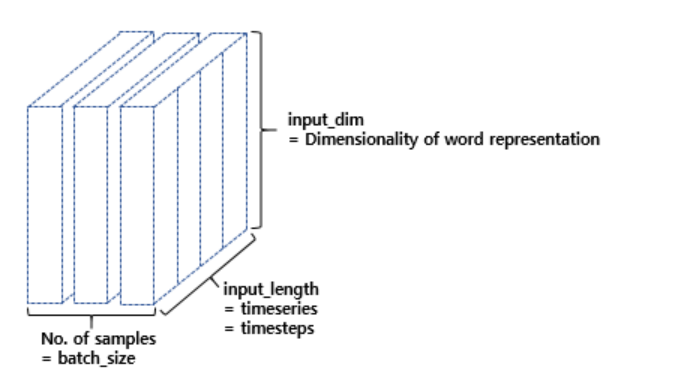

#### **2) 모델 설계하기**
하이퍼파라미터인 은닉 상태의 크기는 256입니다. 모델은 다 대 다 구조의 LSTM을 사용하며, LSTM 은닉층은 두 개를 사용합니다. 전결합층(Fully Connected Layer)을 출력층으로 문자 집합 크기만큼의 뉴런을 배치하여 모델을 설계합니다. 해당 모델은 모든 시점에서 모든 가능한 문자 중 하나의 문자를 예측하는 다중 클래스 분류 문제를 수행하는 모델입니다. 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용하여 80 에포크를 수행합니다.

In [29]:
train_X.shape

(2337, 60, 43)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

hidden_units = 256

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(None, train_X.shape[2]), return_sequences=True)) # None:문장수, 
model.add(LSTM(hidden_units, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))  # 모든 time squence의 Hidden에서 출력발생
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, None, 256)      │       307,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, None, 256)      │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 43)       │        11,051 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 843,563 (3.22 MB)

 Trainable params: 843,563 (3.22 MB)

 Non-trainable params: 0 (0.00 B)

특정 문자를 주면 다음 문자를 계속해서 생성해내는 sentence_generation 함수를 구현합니다. 인자로 학습한 모델. 그리고 모델로 다음 문자를 몇 번 생성할 것인지 횟수를 전달해주면, 해당 함수는 임의로 시작 문자를 정한 뒤에 정해진 횟수만큼의 다음 문자를 지속적으로 예측하여 문장을 생성해냅니다.

In [32]:
train_X.shape, train_y.shape

((2337, 60, 43), (2337, 60, 43))

In [33]:
%%time
# GPU 사용
# Epoch 80/80
# 84/84 - 1s - loss: 0.1866 - accuracy: 0.9558 - 873ms/epoch - 10ms/step
# CPU times: user 1min 20s, sys: 4.56 s, total: 1min 25s
# Wall time: 1min 19s

# 노트북 : 74/74 - 12s - 163ms/step - accuracy: 0.9649 - loss: 0.1356
# CPU times: total: 14min 16s
# Wall time: 16min 21s
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_X, train_y, epochs=70, verbose=1)

Epoch 1/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.1740 - loss: 3.1980
Epoch 2/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.2081 - loss: 2.8467
Epoch 3/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.3204 - loss: 2.4083
Epoch 4/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.3668 - loss: 2.2214
Epoch 5/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.3985 - loss: 2.1066
Epoch 6/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.4052 - loss: 2.0713
Epoch 7/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.4299 - loss: 1.9728
Epoch 8/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.4449 - loss: 1.9091
Epoch 9/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.4587 - loss: 1.8605
Epoch 10/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.4741 - loss: 1.8056
Epoch 11/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.4832 - loss: 1.7670
Epoch 12/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 10

<Axes: >

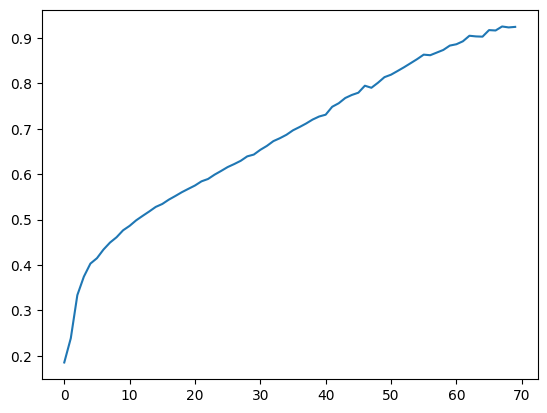

In [34]:
import pandas as pd
pd.DataFrame(history.history)['accuracy'].plot()

<Axes: >

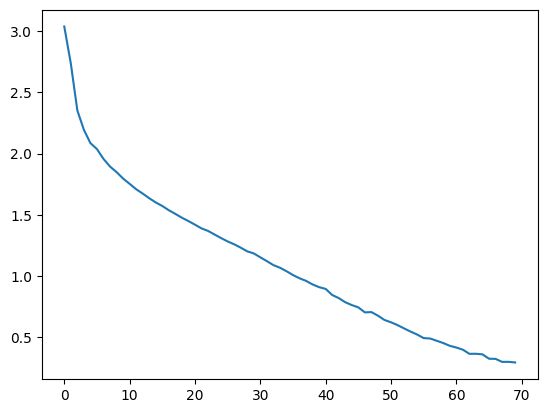

In [35]:
pd.DataFrame(history.history)['loss'].plot()

In [36]:
## 임의의 문자 선택
ix = [np.random.randint(vocab_size)]
ix

[6]

In [37]:
## 임의의 단어 인덱스에 해당하는 문자
y_char = [index_to_char[ix[-1]]]
y_char

['-']

In [38]:
def sentence_generation(model, length):
    # 글자에 대한 랜덤 인덱스 생성
    ix = [np.random.randint(vocab_size)]

    # 랜덤 익덱스로부터 글자 생성
    y_char = [index_to_char[ix[-1]]]
    print(ix[-1],'번 글자', y_char[-1],'로 예측을 시작!')

    # (1, length, 55) 크기의 X 생성. 즉, LSTM의 입력 시퀀스 생성
    X = np.zeros((1, length, vocab_size))  # 문장단위를 X로 설정하여 초기화(0)

    for i in range(length):
        # X[0][i][예측한 글자의 인덱스] = 1, 즉, 예측 글자를 다음 입력 시퀀스에 추가 (원핫벡터로)
        X[0][i][ix[-1]] = 1
        print(index_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :], verbose=0)[0], 1)
        y_char.append(index_to_char[ix[-1]])
    return ('').join(y_char)

In [45]:
result = sentence_generation(model, 100)  # 임의의 문자로 시작하는 100자짜리 문장을 생성!
print(result)

28 번 글자 l 로 예측을 시작!
leased tone. prope chimney to the time, as it sid nothing. she had not gonning to the other: i such leased tone. prope chimney to the time, as it sid nothing. she had not gonning to the other: i such a


자세히 보면 사실 말이 되지 않는 문장이지만, 언뜻 보기에 그럴듯해 보이는 문장을 생성해냅니다.

### **2. 문자 단위 RNN(Char RNN)으로 텍스트 생성하기**

이번에는 **다 대 일(many-to-one) 구조의 RNN** 을 **글자 단위로 학습** 시키고, **텍스트 생성** 을 해보겠습니다.



#### **1) 데이터에 대한 이해와 전처리**

In [40]:
import numpy as np
from tensorflow.keras.utils import to_categorical

다음과 같이 제가 임의로 만든 엉터리 노래 가사가 있습니다.

In [46]:
raw_text = '''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''

위의 텍스트에 존재하는 단락 구분을 없애고 하나의 문자열로 재저장하겠습니다.

In [47]:
tokens = raw_text.split()
raw_text = ' '.join(tokens)
print(raw_text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


단락 구분이 없어지고 하나의 문자열로 재저장되었습니다. 이로부터 문자 집합을 만들어보겠습니다. 기존에는 중복을 제거한 단어들의 모음인 단어 집합(vocabulary)을 만들었으나, 이번에 만들 집합은 단어 집합이 아니라 문자 집합입니다.

In [48]:
# 중복을 제거한 글자 집합 생성
char_vocab = sorted(list(set(raw_text)))
print('문자 집합 :', char_vocab)

문자 집합 : [' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [49]:
vocab_size = len(char_vocab)
print ('글자 집합의 크기 : {}'.format(vocab_size))

글자 집합의 크기 : 33


알파벳 또는 구두점 등의 단위의 집합인 문자 집합이 생성되었습니다. 문자 집합의 크기는 33입니다.

In [50]:
char_to_index = dict((c, i) for i, c in enumerate(char_vocab)) # 글자에 고유한 정수 인덱스 부여
print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


이번 실습의 문자 집합의 경우 훈련 데이터에 등장한 알파벳의 **대, 소문자를 구분하고 구두점과 공백을 포함** 하였습니다. 이제 훈련에 사용할 문장 샘플들을 만들어보겠습니다. 여기서는 RNN을 이용한 생성한 텍스트 챕터와 유사하게 데이터를 구성합니다. 다만, 단위가 문자 단위라는 점이 다릅니다. 예를 들어 훈련 데이터에 student라는 단어가 있고, 입력 시퀀스의 길이를 5라고 한다면 입력 시퀀스와 예측해야하는 문자는 다음과 같이 구성됩니다. 5개의 입력 문자 시퀀스로부터 다음 문자 시퀀스를 예측하는 것입니다. 즉, RNN의 시점(timesteps)은 5번입니다.

* stude -> n
* tuden -> t  

여기서는 입력 시퀀스의 길이가 10가 되도록 데이터를 구성하겠습니다. 예측 대상인 문자도 필요하므로 길이가 11이 되도록 데이터를 구성합니다.

In [51]:
length = 10
sequences = []
for i in range(length, len(raw_text)):
    seq = raw_text[i - length: i] # 길이 10의 문자열을 지속적으로 만든다.
    sequences.append(seq)
print('총 훈련 샘플의 수: %d' % len(sequences))

총 훈련 샘플의 수: 427


총 샘플의 수는 426개가 완성되었습니다. 이 중 10개만 출력해보겠습니다.

In [52]:
sequences[:10]

['I get on w',
 ' get on wi',
 'get on wit',
 'et on with',
 't on with ',
 ' on with l',
 'on with li',
 'n with lif',
 ' with life',
 'with life ']

In [53]:
len(sequences), sequences

(427,
 ['I get on w',
  ' get on wi',
  'get on wit',
  'et on with',
  't on with ',
  ' on with l',
  'on with li',
  'n with lif',
  ' with life',
  'with life ',
  'ith life a',
  'th life as',
  'h life as ',
  ' life as a',
  'life as a ',
  'ife as a p',
  'fe as a pr',
  'e as a pro',
  ' as a prog',
  'as a progr',
  's a progra',
  ' a program',
  'a programm',
  ' programme',
  'programmer',
  'rogrammer,',
  'ogrammer, ',
  'grammer, I',
  'rammer, I ',
  'ammer, I l',
  'mmer, I li',
  'mer, I lik',
  'er, I like',
  'r, I like ',
  ', I like t',
  ' I like to',
  'I like to ',
  ' like to c',
  'like to co',
  'ike to con',
  'ke to cont',
  'e to conte',
  ' to contem',
  'to contemp',
  'o contempl',
  ' contempla',
  'contemplat',
  'ontemplate',
  'ntemplate ',
  'template b',
  'emplate be',
  'mplate bee',
  'plate beer',
  'late beer.',
  'ate beer. ',
  'te beer. B',
  'e beer. Bu',
  ' beer. But',
  'beer. But ',
  'eer. But w',
  'er. But wh',
  'r. But whe',
  

첫번째 문장이었던 'I get on with life as a programmer,'가 10개의 샘플로 분리된 것을 확인할 수 있습니다. 다른 문장들에 대해서도 sequences에 모두 저장되어져 있습니다. 원한다면, sequences[30:45] 등과 같이 인덱스 범위를 변경하여 출력해보시기 바랍니다. 이제 앞서 만든 char_to_index를 사용하여 전체 데이터에 대해서 정수 인코딩을 수행합니다.

In [54]:
encoded_sequences = []
for sequence in sequences: # 전체 데이터에서 문장 샘플을 1개씩 꺼낸다.
    encoded_sequence = [char_to_index[char] for char in sequence] # 문장 샘플에서 각 글자에 대해서 정수 인코딩을 수행.
    encoded_sequences.append(encoded_sequence)

정수 인코딩 된 결과가 X에 저장되었습니다. 5개만 출력해보겠습니다.

In [55]:
encoded_sequences[:5]

[[8, 0, 16, 14, 28, 0, 24, 23, 0, 31],
 [0, 16, 14, 28, 0, 24, 23, 0, 31, 18],
 [16, 14, 28, 0, 24, 23, 0, 31, 18, 28],
 [14, 28, 0, 24, 23, 0, 31, 18, 28, 17],
 [28, 0, 24, 23, 0, 31, 18, 28, 17, 0]]

정수 인코딩이 수행되었습니다. 예측 대상인 문자를 분리시켜주는 작업을 해봅시다. 모든 샘플 문장에 대해서 마지막 문자를 분리하여 마지막 문자가 분리된 샘플은 X_data에 저장하고, 마지막 문자는 y_data에 저장합니다.

In [56]:
encoded_sequences = np.array(encoded_sequences)
X_data = encoded_sequences[:, :-1]

# 맨 마지막 위치의 글자를 분리
y_data = encoded_sequences[:, -1]

In [57]:
encoded_sequences.shape

(427, 10)

In [58]:
X_data.shape

(427, 9)

In [59]:
y_data.shape

(427,)

정상적으로 분리가 되었는지 X와 y 둘 다 5개씩 출력해보겠습니다.

In [60]:
print(X_data[:5])
print(y_data[:5])

[[ 8  0 16 14 28  0 24 23  0]
 [ 0 16 14 28  0 24 23  0 31]
 [16 14 28  0 24 23  0 31 18]
 [14 28  0 24 23  0 31 18 28]
 [28  0 24 23  0 31 18 28 17]]
[31 18 28 17  0]


앞서 출력한 5개의 샘플에서 각각 맨 뒤의 문자였던 18, 28, 17, 0, 21이 별도로 분리되어 y에 저장되었습니다. 이제 X와 y에 대해서 원-핫 인코딩을 수행해보겠습니다.

In [61]:
# 원-핫 인코딩
X_data_one_hot = [to_categorical(encoded, num_classes=vocab_size) for encoded in X_data]
X_data_one_hot = np.array(X_data_one_hot)
y_data_one_hot = to_categorical(y_data, num_classes=vocab_size)

원-핫 인코딩이 수행되었는지 확인하기 위해 수행한 후의 X의 크기(shape)를 보겠습니다.

In [62]:
print(X_data_one_hot.shape)

(427, 9, 33)


현재 X의 크기는 426 × 10 × 33 입니다.  
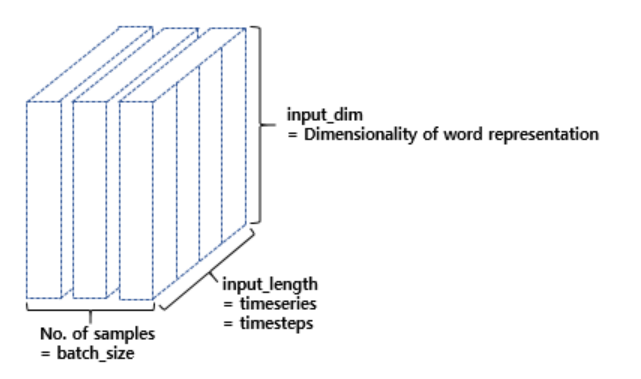

이는 샘플의 수(No. of samples)가 426개, 입력 시퀀스의 길이(input_length)가 10, 각 벡터의 차원(input_dim)이 33임을 의미합니다. 원-핫 벡터의 차원은 문자 집합의 크기인 33이어야 하므로 X에 대해서 원-핫 인코딩이 수행되었음을 알 수 있습니다.

#### **2) 모델 설계하기**
하이퍼파라미터인 은닉 상태의 크기는 64입니다. 모델은 다 대 일 구조의 LSTM을 사용합니다. 전결합층(Fully Connected Layer)을 출력층으로 문자 집합 크기만큼의 뉴런을 배치하여 모델을 설계합니다. 해당 모델은 마지막 시점에서 모든 가능한 문자 중 하나의 문자를 예측하는 다중 클래스 분류 문제를 수행하는 모델입니다. 다중 클래스 분류 문제의 경우, 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용하여 100 에포크를 수행합니다.

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [64]:
hidden_units = 64

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(X_data_one_hot.shape[1], X_data_one_hot.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))
model.summary()

c:\Users\dlwlg\anaconda3\envs\py310_yolo\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 33)             │         2,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,233 (106.38 KB)

 Trainable params: 27,233 (106.38 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
X_data_one_hot.shape

(427, 9, 33)

In [66]:
%%time 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_data_one_hot, y_data_one_hot, epochs=100, verbose=2)

Epoch 1/100
14/14 - 2s - 113ms/step - accuracy: 0.1475 - loss: 3.4602
Epoch 2/100
14/14 - 0s - 7ms/step - accuracy: 0.1944 - loss: 3.3495
Epoch 3/100
14/14 - 0s - 7ms/step - accuracy: 0.1967 - loss: 3.0862
Epoch 4/100
14/14 - 0s - 7ms/step - accuracy: 0.1967 - loss: 2.9961
Epoch 5/100
14/14 - 0s - 7ms/step - accuracy: 0.1967 - loss: 2.9592
Epoch 6/100
14/14 - 0s - 8ms/step - accuracy: 0.1967 - loss: 2.9431
Epoch 7/100
14/14 - 0s - 7ms/step - accuracy: 0.1967 - loss: 2.9209
Epoch 8/100
14/14 - 0s - 7ms/step - accuracy: 0.1967 - loss: 2.8990
Epoch 9/100
14/14 - 0s - 7ms/step - accuracy: 0.1967 - loss: 2.8844
Epoch 10/100
14/14 - 0s - 7ms/step - accuracy: 0.1967 - loss: 2.8546
Epoch 11/100
14/14 - 0s - 7ms/step - accuracy: 0.1967 - loss: 2.8292
Epoch 12/100
14/14 - 0s - 7ms/step - accuracy: 0.2014 - loss: 2.7999
Epoch 13/100
14/14 - 0s - 7ms/step - accuracy: 0.2108 - loss: 2.7601
Epoch 14/100
14/14 - 0s - 7ms/step - accuracy: 0.2131 - loss: 2.7239
Epoch 15/100
14/14 - 0s - 7ms/step - accu

<Axes: >

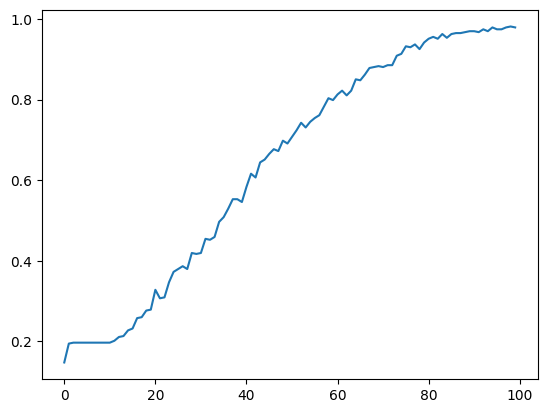

In [69]:
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history.accuracy.plot()

<Axes: >

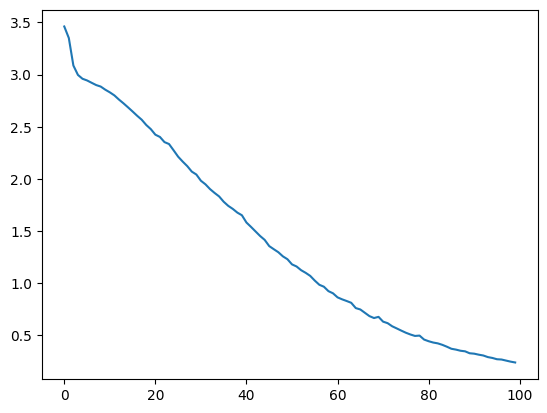

In [70]:
df_history.loss.plot()

문장을 생성하는 함수 sentence_generation을 만들어서 문장을 생성해봅시다. 해당 함수는 문자열을 입력하면, 해당 문자열로부터 다음 문자를 예측하는 것을 반복하여 최종적으로 문장을 완성합니다.

In [71]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):

    # 초기 시퀀스
    init_text = seed_text
    sentence = ''

    for _ in range(n):
        encoded = [char_to_index[char] for char in seed_text] # 현재 시퀀스에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre') # 데이터에 대한 패딩
        encoded = to_categorical(encoded, num_classes=len(char_to_index))

        # 입력한 X(현재 시퀀스)에 대해서 y를 예측하고 y(예측한 글자)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)
        
        for char, index in char_to_index.items():
            if index == result:
                break

        # 현재 시퀀스 + 예측 글자를 현재 시퀀스로 변경
        seed_text = seed_text + char

        # 예측 글자를 문장에 저장
        sentence = sentence + char

    sentence = init_text + sentence
    return sentence

In [74]:
print(sentence_generation(model, char_to_index, 10, 'I get on w', 80))

I get on wwith life saraa prut yormiier,, I wike mih thtnnenaareee li loei aa  renrggaamrg


두 개의 문장이 출력되었습니다. 이 두 문장은 훈련 데이터에서는 연속적으로 나온 적이 없는 두 문장임에도 모델이 임의로 생성해냈습니다.

In [75]:
print(sentence_generation(model, char_to_index, 20, 'I like', 80))

I likettt thhhhant  esatMo asttt  tuss dtt hitredrsss satuttrtt tp hhhhh mimraaaoocctt


In [ ]:
1